# Simulating a Lidar

We read our pgm file using mathplotlib.

We then convert the image representation which uses a cordinate system with (0,0) in the top left corner to a carthesian coordinate system.

We then place the robot with the lidar on the map using xy coordinates and yaw as the orientation. We transform the points of the map to the lidar coordinate system and then convert the carthesian coordinate system to a polar coordinate system. We use a simplified robot that consists of only a point 

We sweep a full circle around the Lidar in segments which size depends on the Lidar resolution and we retain the closest point to construct our lidar scann.

In [1]:
import matplotlib.pyplot as plt
with open("piste.pgm", 'rb') as pgmf:
    img = plt.imread(pgmf)

In [2]:
import numpy as np

In [3]:
pose = [900, 500, np.pi]

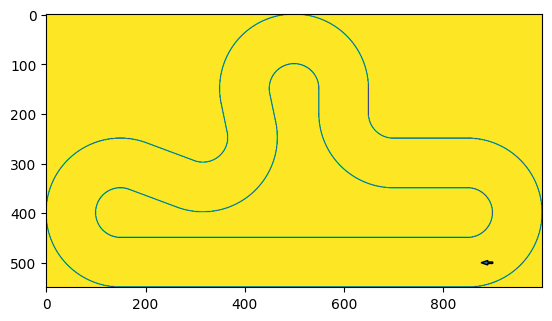

In [4]:
%matplotlib inline
imgplot = plt.imshow(img)
plt.arrow(pose[0], pose[1], 10 * np.cos(pose[2]), 10 * np.sin(pose[2]), width=3.0)

## convert to carthesian coordinate system

In [5]:
img_t = np.transpose(img)
img_t = np.flip(img_t, 1)

In [6]:
threshold = 250

In [7]:
width = img_t.shape[0]
height = img_t.shape[1]
t = np.mgrid[:width, :height]
t = np.stack((t[0], t[1]), axis=2)

In [8]:
points = t[img_t < threshold]

In [9]:
pose = [900, 50, np.pi]
pose = [500, 50, np.radians(-3)]
#pose = [500, 50, 0]
#pose = [850, 52, 3.0892327760299634]
pose = [753, 77, 2.792526803190927]
pose = [ 166.648113,  213.283612,  0.20943951]
pose = [ 215.555493,  223.679196,  0.20943951]
pose = [ 260.735529,  234.518542,  0.2268928 ]
pose = [107.199835, 189.184783, 1.30899694]
pose = [107, 189, 1.30899694]

## Transform to Lidar Frame

In [10]:
theta = -pose[2]
rot_matrix = np.array([[np.cos(theta), -np.sin(theta),0],
                       [np.sin(theta), np.cos(theta), 0],
                       [0, 0, 1]])

trans_matrix = np.array([[1, 0, -pose[0]],
                       [0, 1, -pose[1]],
                       [0, 0, 1]])

points_pose = np.transpose(trans_matrix @ np.vstack([np.transpose(points), np.ones(points.shape[0])]))
points_pose = np.transpose(rot_matrix @ np.transpose(points_pose))

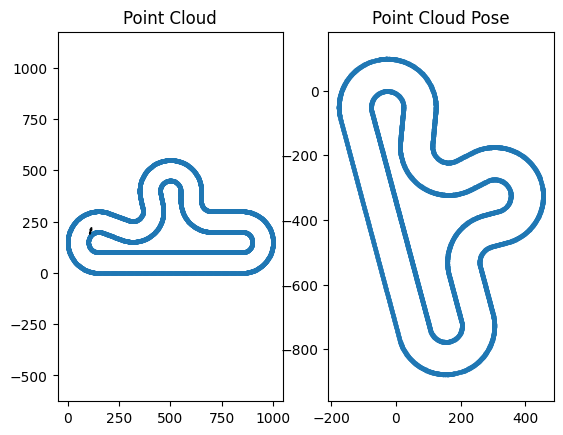

In [11]:
fig, axs = plt.subplots(1, 2)
axs[0].set_title("Point Cloud")  
axs[0].axis('equal')
axs[0].scatter(points[:, 0], points[:, 1], s=3.0)
axs[0].arrow(pose[0], pose[1], 20 * np.cos(pose[2]), 20 * np.sin(pose[2]), width=3.0)
axs[1].set_title("Point Cloud Pose")  
axs[1].axis('equal')
axs[1].scatter(points_pose[:, 0], points_pose[:, 1], s=3.0)

In [12]:
points_magnify = points_pose[(points_pose[:, 0] < 0) & (points_pose[:, 0] > -80)]
points_magnify = points_magnify[(points_magnify[:, 1] < 0) & (points_magnify[:, 1] > -20)]

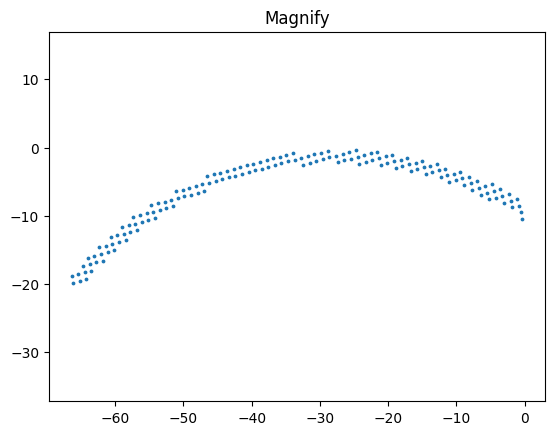

In [13]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Magnify")  
ax.axis('equal')
ax.scatter(points_magnify[:, 0], points_magnify[:, 1], s=3.0)

## Convert to polar coordinate system

In [14]:
import cmath
def cart2polC(xyz):
    x, y, z = xyz
    return(cmath.polar(complex(x, y))) # rho, phi
def convert_array(arr):
    theta = []
    r = []
    for x in arr:
        rho, phi = cart2polC(x)
        theta.append(phi)
        r.append(rho)
    return theta, r    

In [15]:
theta, r = convert_array(points_pose)
polar_points = np.column_stack((np.array(theta), np.array(r)))

In [16]:
# Debugging
#polar_points = polar_points[(polar_points[:, 0] > np.radians(-170.5)) & (polar_points[:, 0] < np.radians(-165.5))]

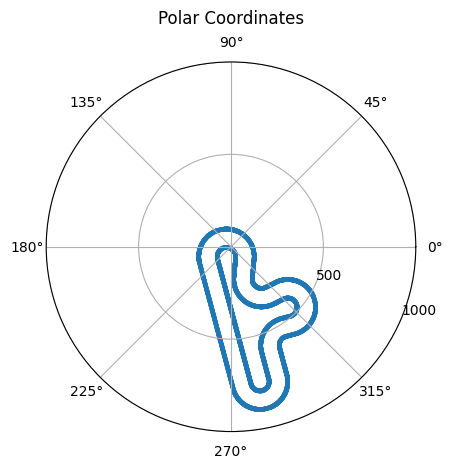

In [17]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(polar_points[:, 0], polar_points[:, 1], s=3.0)
ax.set_rmax(1000)
ax.set_rticks([500, 1000])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("Polar Coordinates", va='bottom')
plt.show()

## Filter closest points

In [18]:
min_range = 2.0
max_range = 12000.0
resolution = 1 # in degrees
def lidar_filer(raw_scann):
    scann = []
    samples = np.arange(-np.pi, np.pi, np.radians(resolution))
    for sample in samples:
        mask = (raw_scann[:,0] > sample - np.radians(resolution) / 2) & (raw_scann[:,0] < sample + np.radians(resolution) / 2)
        if sum(mask) == 0:
            dist = 0
        else:
            dist = raw_scann[mask][:, 1].min()
        scann.append(dist)
        if dist > max_range:
            scann[-1] = None
        if dist < min_range:
            scann[-1] = None
    return np.roll(np.array(scann), int(np.pi / np.radians(resolution)))       

In [19]:
lidar_scann = lidar_filer(polar_points)

In [20]:
plot_scann = np.stack((np.arange(0, 2 * np.pi, np.radians(resolution)), lidar_scann), axis=1)
plot_scann = plot_scann[plot_scann[:, 1] != np.array(None)]

Text(0.5, 1.0, 'Lidar Scann')

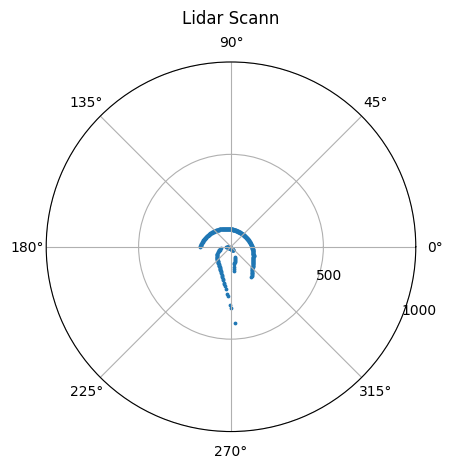

In [21]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(plot_scann[:, 0], plot_scann[:, 1], s=3.0)
ax.set_rmax(1000)
ax.set_rticks([500, 1000])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("Lidar Scann", va='bottom')